#  Install package

In [213]:
# ! pip install pyvis
# ! pip install networkx
# ! pip install dash
# ! pip install altair
# ! pip install panel

# Import package

In [214]:
import os
import requests
import networkx as nx
import pandas as pd
import geopandas as gpd
from pyvis.network import Network
import openai
from IPython.display import display, HTML, Code
from IPython.display import clear_output


# Define Solution class
Please run the following cell to define the functions

In [215]:
# %load_ext autoreload
# %autoreload 2

import LLM_Geo_Constants as constants
import helper
# import LLM_Geo_kernel.Solution as Solution

from LLM_Geo_kernel import Solution

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Demonstration Cases

## Input task and data desciption

In [216]:
# Case 1: population living near hazardous wastes

# task_name ='Resident_at_risk_counting'

# TASK = r"""1) Find out the total population that lives within a tract that contain hazardous waste facilities. The study area is North Carolina, US.
# 2) Generate a map to show the spatial distribution of population at the tract level and highlight the borders of tracts that have hazardous waste facilities.
# """

# DATA_LOCATIONS = ["NC hazardous waste facility ESRI shape file location: https://github.com/gladcolor/LLM- Geo/raw/master/overlay_analysis/Hazardous_Waste_Sites.zip.",
#                   "NC tract boundary shapefile location: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_shp_37.zip. The tract id column is 'Tract'.",
#                   "NC tract population CSV file location: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv. The population is stored in 'TotalPopulation' column. The tract ID column is 'GEOID'."
#                  ]


# Case 2: France_mobility_changes_2020
task_name ='France_mobility_changes_2020'
TASK = r'''
1) Show the 2020 human mobility monthly change rates of each administrative regions in a France choropleth map. Each month is a sub-map in a map matrix，12 months in total. All monthly maps need to use the same colorbar range. The base of the change rate is January 2020. 
2) Draw a line chart to show the monthly change rate trends of all administrative regeions. Each region is a line (the region name is the legend), the x-axis is 2020 months.
'''

DATA_LOCATIONS = ["ESRI shapefile for France administrative regions:" + \
                  "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip. " + \
                  "The 'GID_1' column is the administrative region code, 'NAME_1' column is the administrative region name.",
                  "REST API url with parameters for human mobility data access:" + \
                  "http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020." + \
                  "The response is in CSV format. There are three columns in the response: " + \
                  "place,date (format:2020-01-07), and intra_movement. 'place' column is the administractive region code of every country; codes for France administrative regions start with 'FRA'.",
                 ]

  
# Case 3: COVID-19 prevalence trend
# task_name ='COVID_death_rate'
# TASK = r'''1) Draw a map to show the death rate (death/case) of COVID-19 among the countiguous US counties. Use the accumulated COVID-19 data of 2020.12.31 to compute the death rate. Use scheme ='quantiles' when plotting the map.  Set map projection to 'Conus Albers'. Set map size to 15*10 inches.  
# 2) Draw a scatter plot to show the correlation and trend line of the death rate with the senior resident rate, including the r-square and p-value. Set data point transparency to 50%, regression line as red.  Set figure size to 15*10 inches.  
# '''

# DATA_LOCATIONS = [
#                   r"COVID-19 data case in 2020 (county-level): https://github.com/nytimes/covid-19-data/raw/master/us-counties-2020.csv. This data is for daily accumulated COVID cases and deaths for each county in the US. There are 5 columns: date (format: 2021-02-01), county, state, fips, cases, deaths. ",   
#                   r"Contiguous US county boundary (ESRI shapefile): https://github.com/gladcolor/spatial_data/raw/master/contiguous_counties.zip. The county FIPS column is 'GEOID'. ",
#                   r"Census data (ACS2020): https://raw.githubusercontent.com/gladcolor/spatial_data/master/Demography/ACS2020_5year_county.csv. THe needed columns are: 'FIPS', 'Total Population', 'Total Population: 65 to 74 Years', 'Total Population: 75 to 84 Years', 'Total Population: 85 Years and Over'. Drop rows with NaN cells after loading the used columns.",
#                  ]



# # Case 4: Hospital_accessibility
# task_name ='Hospital_accessibility'
# TASK = r'''
# For each zipcode area in South Carolina (SC), calculate the distance from the centroid of the zipcode area to its nearest hospital, and then create a choropleth distance map of zipcode area polygons (unit: km), also show the hospital.
# '''

# DATA_LOCATIONS = [
# r"SC zipcode boundary shapefile: https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip, the map projection is WGS1984.",
# r"SC hospitals:  https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv, location columns: longitude in 'POINT_X' column, latitude in 'POINT_Y' column.",          
# ]


  
save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)

# create graph
# model=r"gpt-3.5-turbo"
model=r"gpt-4"
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    model=model,
                    )
print("Prompt to get solution graph:\n")
# print(solution.graph_prompt)
print(solution.chat_history)

Prompt to get solution graph:

[{'role': 'system', 'content': 'A professional Geo-information scientist and developer good at Python.'}]


## Get graph code from GPT API

In [217]:
print(solution.chat_history)

[{'role': 'system', 'content': 'A professional Geo-information scientist and developer good at Python.'}]


In [218]:
response_for_graph = solution.get_LLM_response_for_graph() 
# print(solution.chat_history)
solution.graph_response = response_for_graph
solution.save_solution()

clear_output(wait=True)
display(Code(solution.code_for_graph, language='python'))

import networkx as nx

G = nx.DiGraph()

# Nodes: Data
G.add_node("france_admin_shp_url", node_type="data", data_path="https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip", description="France administrative regions shapefile")
G.add_node("rest_api_url", node_type="data", data_path="http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020", description="REST API url for human mobility data")

# Nodes: Operations and Data
G.add_node("load_france_admin_shp", node_type="operation", description="Load France administrative regions shapefile")
G.add_edge("france_admin_shp_url", "load_france_admin_shp")
G.add_node("france_admin_gdf", node_type="data", description="France administrative regions GeoDataFrame")
G.add_edge("load_france_admin_shp", "france_admin_gdf")

G.add_node("load_mobility_data", node_type="operation", description="Load human mobility data from REST API")
G.add_edge("rest_api_url", "load_mobility_data")
G.add_node("mobility_data", node_type="data", description="Human mobility data frame")
G.add_edge("load_mobility_data", "mobility_data")

G.add_node("filter_mobility_data", node_type="operation", description="Filter mobility data for France administrative regions")
G.add_edge("mobility_data", "filter_mobility_data")
G.add_node("filtered_mobility_data", node_type="data", description="Filtered mobility data for France")
G.add_edge("filter_mobility_data", "filtered_mobility_data")

G.add_node("calc_monthly_changes", node_type="operation", description="Calculate monthly change rates of human mobility for France regions")
G.add_edge("filtered_mobility_data", "calc_monthly_changes")
G.add_node("monthly_change_rates", node_type="data", description="Monthly change rates of human mobility for France regions")
G.add_edge("calc_monthly_changes", "monthly_change_rates")

G.add_node("join_mobility_changes", node_type="operation", description="Join monthly change rates to France administrative regions GeoDataFrame")
G.add_edge("monthly_change_rates", "join_mobility_changes")
G.add_edge("france_admin_gdf", "join_mobility_changes")
G.add_node("joined_gdf", node_type="data", description="France administrative regions GeoDataFrame with monthly change rates")
G.add_edge("join_mobility_changes", "joined_gdf")

G.add_node("create_choropleth_maps", node_type="operation", description="Create choropleth maps of France administrative regions with monthly change rates")
G.add_edge("joined_gdf", "create_choropleth_maps")
G.add_node("choropleth_maps", node_type="data", description="Choropleth maps of France administrative regions with monthly change rates")
G.add_edge("create_choropleth_maps", "choropleth_maps")

G.add_node("create_line_chart", node_type="operation", description="Create line chart of monthly change rates for France administrative regions")
G.add_edge("monthly_change_rates", "create_line_chart")
G.add_node("line_chart", node_type="data", description="Line chart of monthly change rates for France administrative regions")
G.add_edge("create_line_chart", "line_chart")


# Save the graph to GraphML format
nx.write_graphml(G, "E:\\Research\\LLM-Geo\\France_mobility_changes_2020\\France_mobility_changes_2020.graphml")

## Execute code to generate the solution graphto generate the solution graph

In [219]:
exec(solution.code_for_graph)
solution_graph = solution.load_graph_file()

# Show the graph
G = nx.read_graphml(solution.graph_file)  
nt = helper.show_graph(G)
html_name = os.path.join(os.getcwd(), solution.task_name + '.html')  
# HTML file should in the same directory. See:
# https://stackoverflow.com/questions/65564916/error-displaying-pyvis-html-inside-jupyter-lab-cell
nt.show(name=html_name)
# html_name

E:\Research\LLM-Geo\France_mobility_changes_2020.html


## Generate prompts and code for operations (functions)

In [220]:
operations = solution.get_LLM_responses_for_operations()
solution.save_solution()

all_operation_code_str = '\n'.join([operation['operation_code'] for operation in operations])

# clear_output(wait=True)
# display(Code(all_operation_code_str, language='python'))

1 / 7, LLM is generating code for operation node: load_france_admin_shp
```python
import geopandas as gpd

def load_france_admin_shp(france_admin_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip'):
    # Description: Load France administrative regions shapefile
    # france_admin_shp_url: URL of the France administrative regions shapefile
    france_admin_gdf = gpd.read_file(france_admin_shp_url)
    return france_admin_gdf
```


LLM is reviewing the operation code... 

```python
import geopandas as gpd

def load_france_admin_shp(france_admin_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip'):
    # Description: Load France administrative regions shapefile
    # france_admin_shp_url: URL of the France administrative regions shapefile
    france_admin_gdf = gpd.read_file(france_admin_shp_url)
    return france_admin_gdf
```



2 / 7, LLM is generating code for operation node: load_mobility_data
```python
import pandas as pd
import 

## Generate prompts and code for assembly program

In [221]:
assembly_LLM_response = solution.get_LLM_assembly_response()
solution.assembly_LLM_response = assembly_LLM_response
solution.save_solution()

# clear_output(wait=True)
# display(Code(solution.code_for_assembly, language='python'))

```python
def assembely_solution():
    # Load France administrative regions shapefile
    france_admin_gdf = load_france_admin_shp()

    # Load and filter human mobility data
    mobility_data = load_mobility_data()
    filtered_mobility_data = filter_mobility_data(mobility_data)

    # Calculate monthly change rates
    monthly_change_rates = calc_monthly_changes(filtered_mobility_data)

    # Join monthly change rates to France administrative regions
    joined_gdf = join_mobility_changes(france_admin_gdf, monthly_change_rates)

    # Create and save choropleth maps
    choropleth_maps = create_choropleth_maps(joined_gdf)
    for i, map_figure in enumerate(choropleth_maps):
        map_figure.savefig(f'France_Monthly_Change_Rate_Map_{i+1}.png')

    # Create and save line chart
    line_chart = create_line_chart(monthly_change_rates)
    plt.savefig('France_Monthly_Change_Rate_Line_Chart.png')

assembely_solution()
```


LLM is reviewing the assembly code... 

```python
import geop

## Execute assembly code



-------------- Running code (trial # 1/10) --------------




--------------- Done ---------------




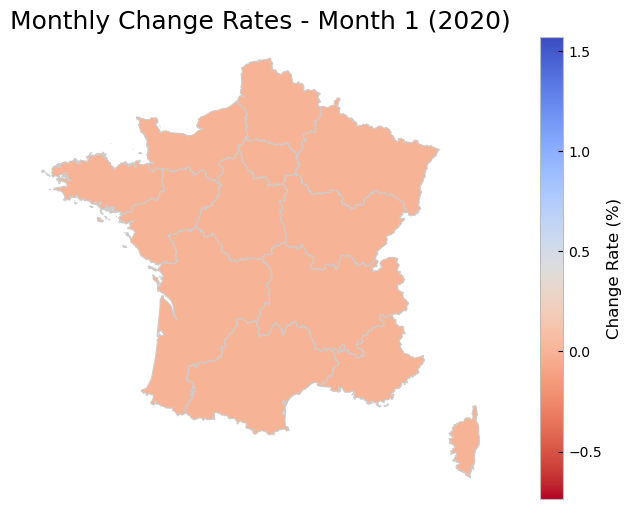

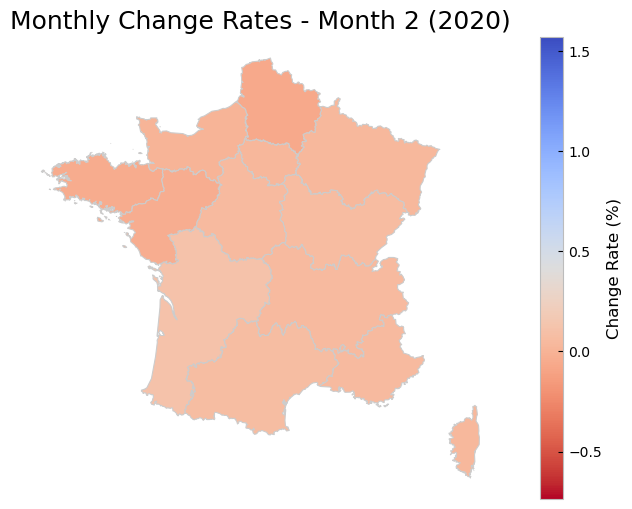

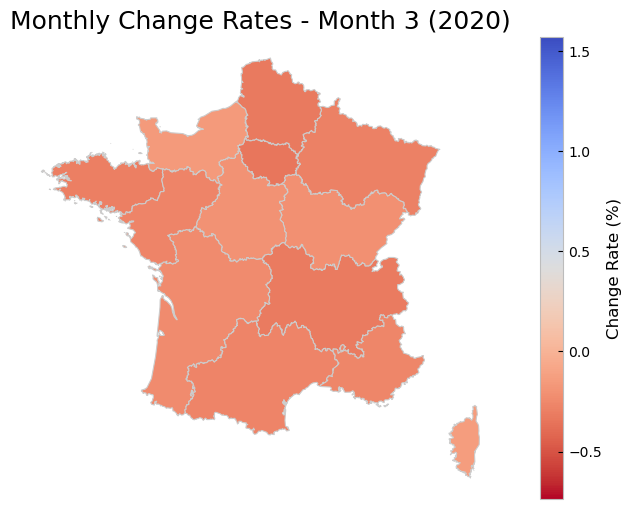

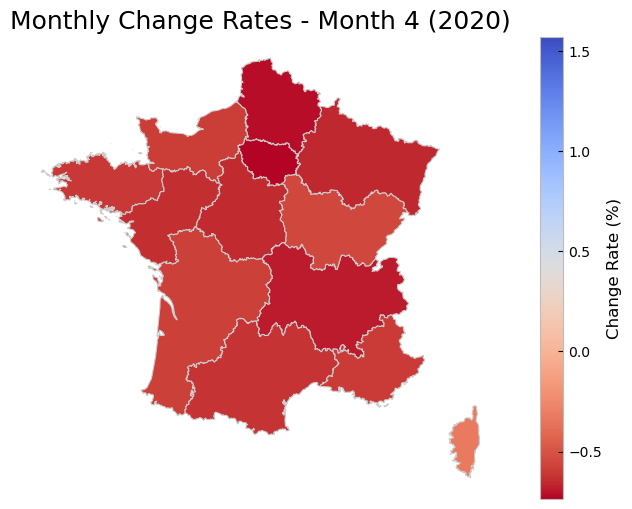

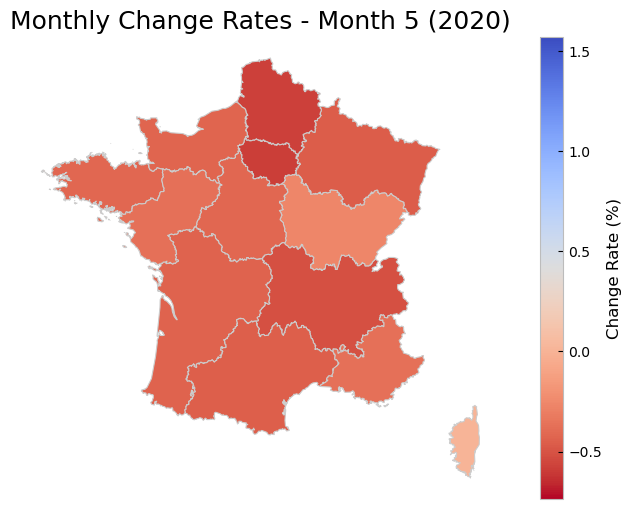

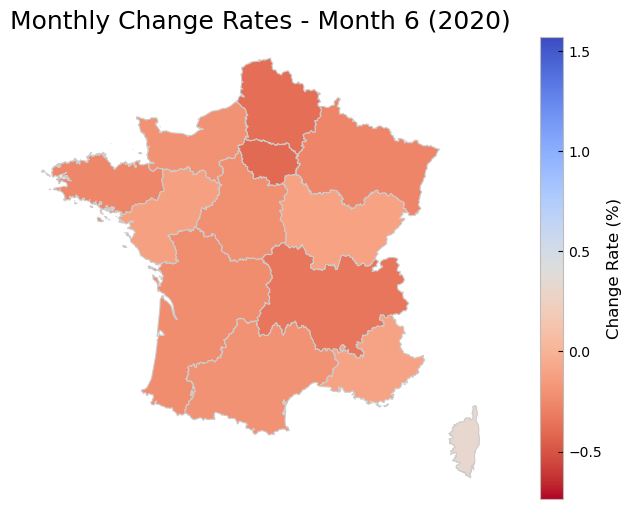

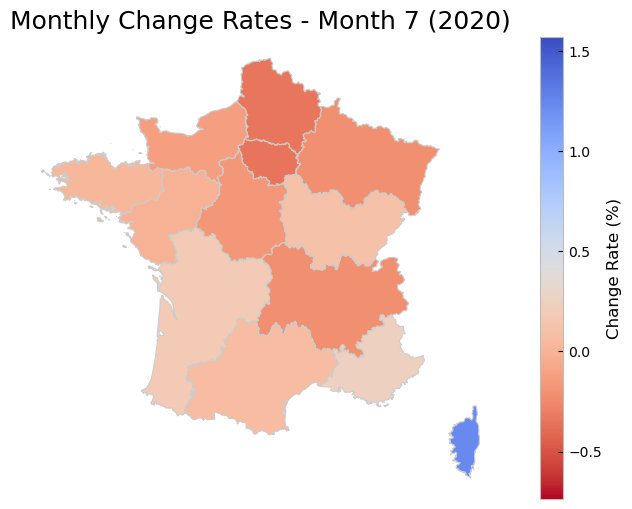

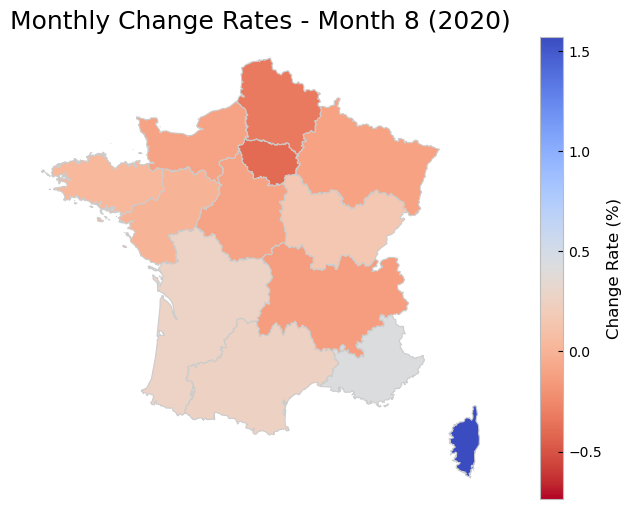

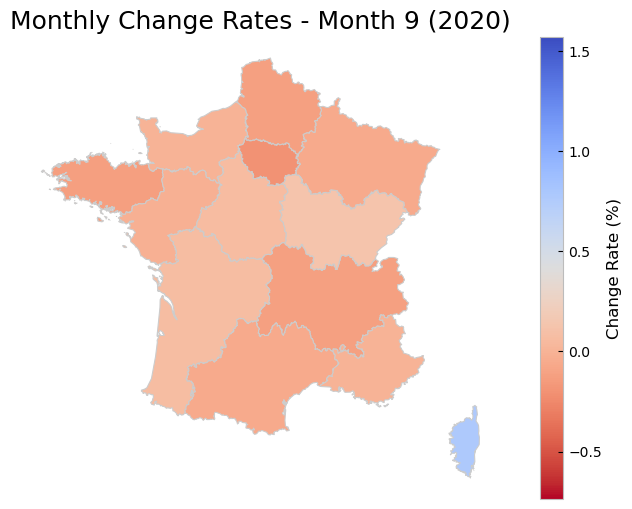

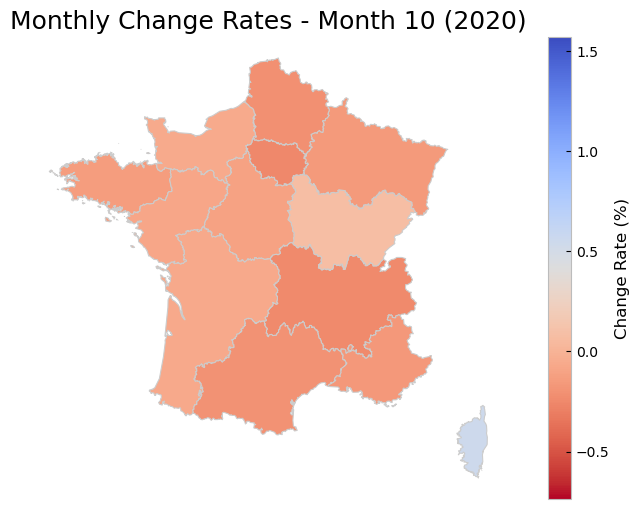

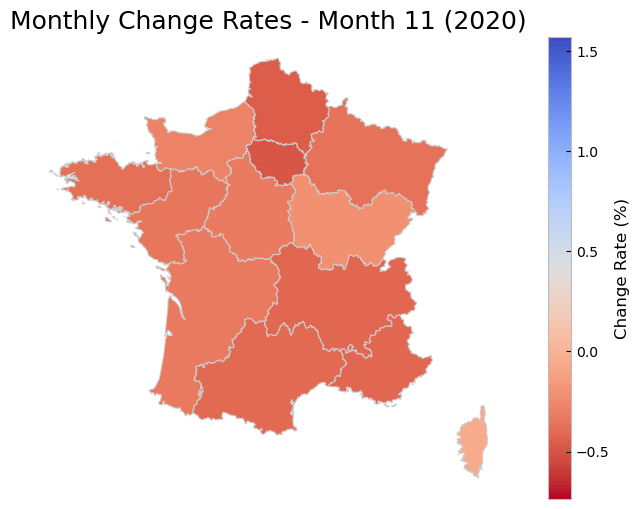

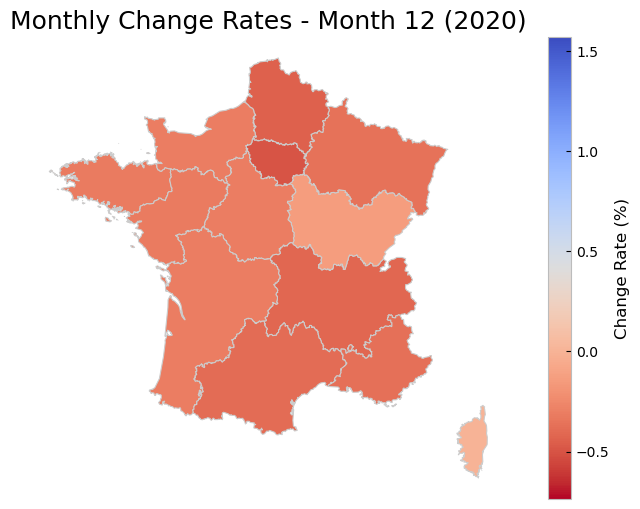

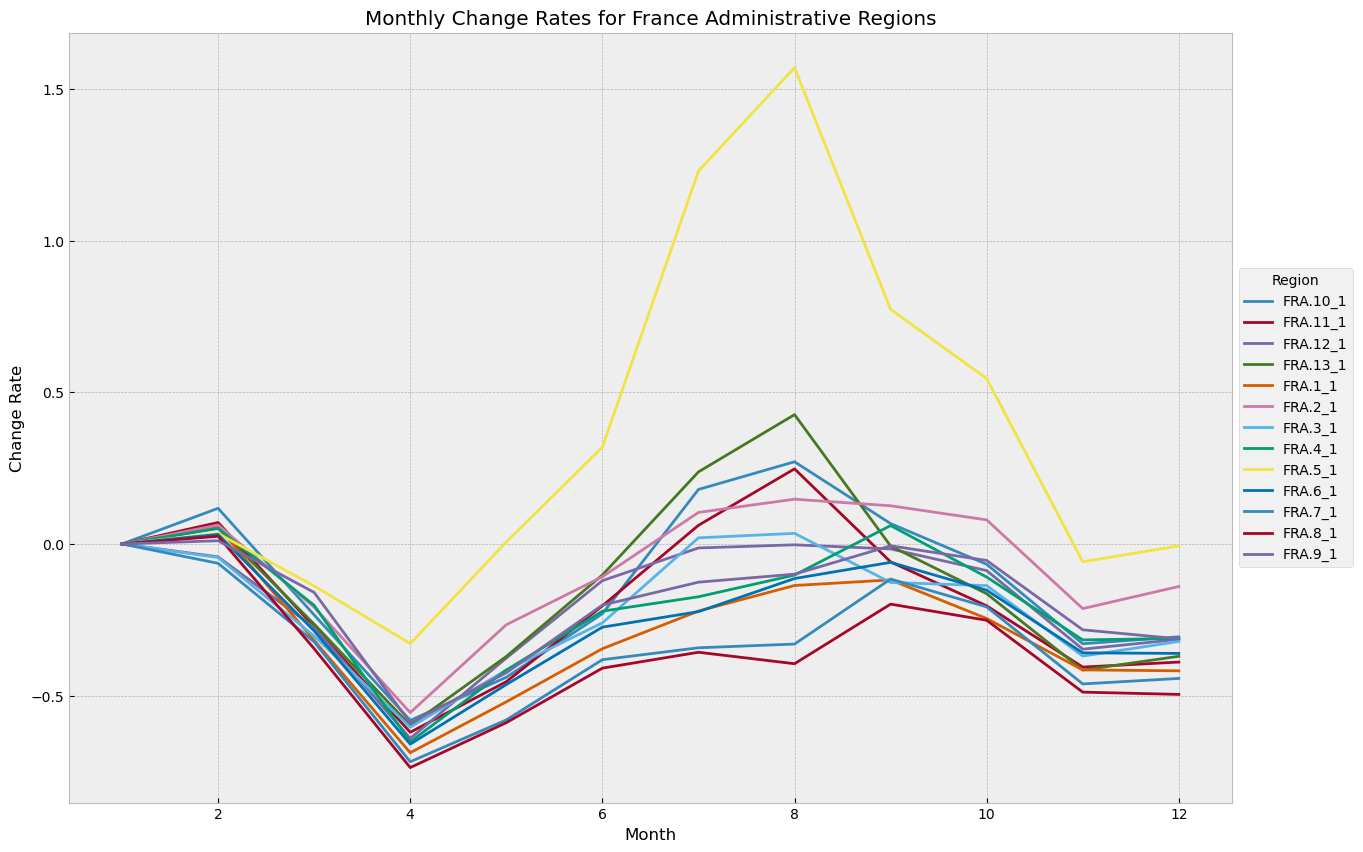

In [222]:
all_code = all_operation_code_str + '\n' + solution.code_for_assembly

# display(Code(all_code, language='python'))

all_code = solution.execute_complete_program(code=all_code, try_cnt=10)

